In [1]:
import random
import string
import numpy as np
from deap import base, creator, tools

In [2]:
class Runner:
    
    def __init__(self, toolbox):
        self.toolbox = toolbox
        self.set_parameters(10, 5, 2)
        
    def set_parameters(self, population_size, iterations, n_matings):
        self.iterations = iterations
        self.population_size = population_size
        self.n_matings = n_matings
        
    def set_fitness(self, population):
        fitnesses = [ 
            (individual, self.toolbox.evaluate(individual)) 
            for individual in population 
        ]

        for individual, fitness in fitnesses:
            individual.fitness.values = (fitness,)
            
    def get_offspring(self, population):
        n = len(population)
        for _ in range(self.n_matings):
            i1, i2 = np.random.choice(range(n), size=2, replace=False)

            offspring1, offspring2 = \
                self.toolbox.mate(population[i1], population[i2])
            
            yield self.toolbox.mutate(offspring1)[0]
            yield self.toolbox.mutate(offspring2)[0]
    
    @staticmethod
    def pull_stats(population, iteration=1):
        fitnesses = [ individual.fitness.values[0] for individual in population ]
        return {
            'i': iteration,
            'mu': np.mean(fitnesses),
            'std': np.std(fitnesses),
            'max': np.max(fitnesses),
            'min': np.min(fitnesses)
        }  
    
    def Run(self):
        population = self.toolbox.population(n=self.population_size)
        self.set_fitness(population)
        
        stats = []
        for iteration in list(range(1, self.iterations + 1)):
            current_population = list(map(self.toolbox.clone, population))
            offspring = list(self.get_offspring(current_population))            
            for child in offspring:
                current_population.append(child)
            
            ## reset fitness,
            self.set_fitness(current_population)
            
            population[:] = self.toolbox.select(current_population, len(population))
            stats.append(
                Runner.pull_stats(population, iteration))
            
        return stats, population

In [3]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

In [4]:
## globals,

random.seed(11);
np.random.seed(121);


INDIVIDUAL_SIZE = NUMBER_OF_CITIES = 100
POPULATION_SIZE = 200
N_ITERATIONS = 1000
N_MATINGS = 50

## 

## fake city names,
cities = [ 
    ''.join(np.random.choice([ c for c in string.ascii_letters ], random.randint(5, 12))) 
    for i in range(NUMBER_OF_CITIES) 
]

## fake distances,
distances = np.zeros((NUMBER_OF_CITIES, NUMBER_OF_CITIES))
for city in range(NUMBER_OF_CITIES):   
    for to_city in [ i for i in range(NUMBER_OF_CITIES) if not i == city ]:
        distances[to_city][city] = \
            distances[city][to_city] = random.randint(50, 2000)

In [5]:
toolbox = base.Toolbox()

## permutation setup for individual,
toolbox.register("indices", random.sample, range(INDIVIDUAL_SIZE), INDIVIDUAL_SIZE)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)

## population setup,
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [6]:
def EVALUATE(individual):
    summation = 0
    start = individual[0]
    for i in range(1, len(individual)):
        end = individual[i]
        summation += distances[start][end]
        start = end
    return summation

toolbox.register("evaluate", EVALUATE)

In [7]:
toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.01)
toolbox.register("select", tools.selTournament, tournsize=10)

In [8]:
a = Runner(toolbox)
a.set_parameters(POPULATION_SIZE, N_ITERATIONS, N_MATINGS)

stats, population = a.Run()

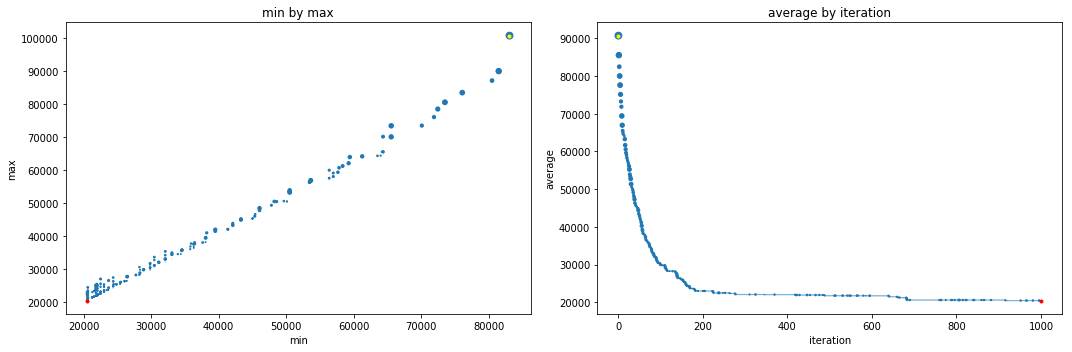

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

_ = plt.scatter([ s['min'] for s in stats ], [ s['max'] for s in stats ], marker='.', s=[ (s['std'] + 1) / 20 for s in stats ])

_ = plt.title('min by max')
_ = plt.xlabel('min')
_ = plt.ylabel('max')

_ = plt.plot(stats[0]['min'], stats[0]['max'], marker='.', color='yellow')
_ = plt.plot(stats[-1]['min'], stats[-1]['max'], marker='.', color='red')


plt.subplot(1,2,2)

_ = plt.scatter([ s['i'] for s in stats ], [ s['mu'] for s in stats ], marker='.', s=[ (s['std'] + 1) / 20 for s in stats ])

_ = plt.title('average by iteration')
_ = plt.xlabel('iteration')
_ = plt.ylabel('average')

_ = plt.plot(stats[0]['i'], stats[0]['mu'], marker='.', color='yellow')
_ = plt.plot(stats[-1]['i'], stats[-1]['mu'], marker='.', color='red')

plt.tight_layout()
plt.show()

In [10]:
fitnesses = sorted([ 
    (i, toolbox.evaluate(individual)) 
    for i, individual in enumerate(population) 
], key=lambda x: x[1])

fitnesses[:5]

[(0, 20491.0), (1, 20491.0), (2, 20491.0), (3, 20491.0), (4, 20491.0)]